<div style="text-align: left; background-color:#00b3b3; font-family:Arial; color:#330000; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">JPEG IMAGE COMPRESSION</div>
<div style="text-align: left; background-color:#fadefc; font-family: Arial; color:#551184; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px">| Bộ môn: Lập trình song song Ứng dụng|</div>


<h1 style="font-family: Arial; color: #000033; text-align: center;">Đồ án nhóm</h1>
<table>
  <tr style="font-size: 20px">
    <th>STT</th>
    <th>Name</th>
    <th>Student ID</th>
  </tr>
  <tr style="font-size: 16px">
    <td>1</td>
    <td>Lê Quang Thọ</td>
    <td>20120588</td>
  </tr>
  <tr style="font-size: 16px">
    <td>2</td>
    <td>Trần Thông Lực</td>
    <td>20120530</td>
  </tr>
</table>

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
    <h3 style="text-align: left; background-color: #ACA224; font-family:newtimeroman; color: white; padding: 14px; line-height: 1; border-radius:10px; font-size: 50px;"><b>Mục lục 📝</b></h3>
    
   * [1. Mô tả ứng dụng](#1)

   * [2. Cài đặt tuần tự](#2)
   * [3. Cài đặt song song](#3)
        - [3.1. Phiên bản song song cơ bản](#3.1)
            - [Phân tích](#3.1.1)
            - [Thiết kế](#3.1.2)
            - [Cài đặt](#3.1.3)
        - [3.2. Phiên bản song song cải tiến 1](#3.2)
            - [Phân tích](#3.2.1)
            - [Thiết kế](#3.2.2)
            - [Cài đặt](#3.2.3)

        - [3.3. Phiên bản song song cải tiến 2](#3.3)
            - [Phân tích](#3.3.1)
            - [Thiết kế](#3.3.2)
            - [Cài đặt](#3.3.3)
        - [3.4. Phiên bản song song cải tiến 3](#3.4)
            - [Phân tích](#3.4.1)
            - [Thiết kế](#3.4.2)
            - [Cài đặt](#3.4.3)
   * [4. Tổng kết](#4)
        - [4.1. Những gì đã làm được](#4.1)
        - [4.2. Những gì chưa làm được](#4.2)
        - [4.3. Những gì sẽ làm](#4.3)
        - [4.4. Khó khăn gặp phải](#4.4)
   * [5. Tài liệu tham khảo](#5)
    

<a id="1"></a>
# <div style="text-align: left; background-color:#004d00; font-family:newtimeroman;color: white; padding: 14px; line-height: 1;border-radius:10px">1. Mô tả ứng dụng</div>
## 1.1. Ứng dụng mà nhóm bạn chọn là gì?
Ở đồ án này nhóm sẽ tiến hành song song hóa các thuật toán nén ảnh JPEG. Bộ dữ liệu được sử dụng trong đồ án này là Human Detection dataset (https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset)
*   Input: Bộ dữ liệu chứa 921 ảnh
*   Output: Các file nén ảnh 
*   Ứng dụng trong thực tế: tăng tốc thuật toán nén ảnh 

## 1.2. Ứng dụng này có cần thiết phải tăng tốc không?
Với các bước được thực hiện tuần tự và riêng biệt tạo ra cơ hội song song hóa và tăng tốc khả năng nén ảnh.

<a id="2"></a>
# <div style="text-align: left; background-color:#004d00; font-family:newtimeroman;color: white; padding: 14px; line-height: 1;border-radius:10px">2. Cài đặt tuần tự</div>

In [2]:
import cv2
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import time
import io
from PIL import Image
import numpy as np
from numba import  cuda, float32, jit, prange, njit

In [3]:

# Function to load dataset of PNG images
def load_dataset(folder_path):
    dataset = []
    # Loop through each file in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is a PNG image
        if filename.endswith('.png'):
            # Load the image using OpenCV
            image = cv2.imread(os.path.join(folder_path, filename))
            # Append the image to the dataset
            dataset.append(image)
    return dataset

# Example usage:
dataset_folder = './human detection dataset/dataset'
png_dataset = load_dataset(dataset_folder)
print("Number of images:", len(png_dataset))


Number of images: 921


<h5> Show the first 10 images

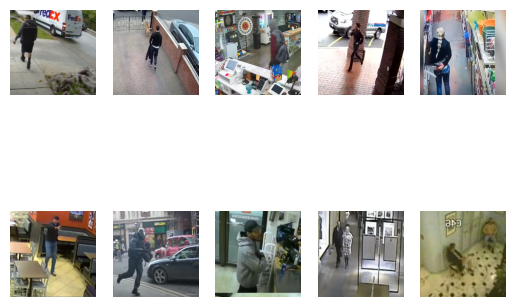

In [4]:
num_images_to_display = 10
for i in range(min(num_images_to_display, len(png_dataset))):
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(png_dataset[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()

Cài đặt một số hàm cần thiết

Hàm zigzag

In [5]:
def zigzag(input):
	h = 0
	v = 0
	vmin = 0
	hmin = 0
	vmax = input.shape[0]
	hmax = input.shape[1]  
	i = 0
	output = np.zeros(( vmax * hmax))
    #----------------------------------
	while ((v < vmax) and (h < hmax)):   	
		if ((h + v) % 2) == 0:               
			if (v == vmin):
				output[i] = input[v, h]       
				if (h == hmax):
					v = v + 1
				else:
					h = h + 1
				i = i + 1
			elif ((h == hmax -1 ) and (v < vmax)):
				output[i] = input[v, h] 
				v = v + 1
				i = i + 1
			elif ((v > vmin) and (h < hmax -1 )):    
				output[i] = input[v, h] 
				v = v - 1
				h = h + 1
				i = i + 1
       
		else:                                   
			if ((v == vmax -1) and (h <= hmax -1)):     
				output[i] = input[v, h] 
				h = h + 1
				i = i + 1       
			elif (h == hmin):                 
				output[i] = input[v, h] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
			elif ((v < vmax -1) and (h > hmin)):    
				output[i] = input[v, h] 
				v = v + 1
				h = h - 1
				i = i + 1
		if ((v == vmax-1) and (h == hmax-1)):         
			output[i] = input[v, h] 
			break

	return output

def inverse_zigzag(input, vmax, hmax):
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))
	i = 0
    #----------------------------------
	while ((v < vmax) and (h < hmax)): 
		if ((h + v) % 2) == 0:                     
			if (v == vmin):
				output[v, h] = input[i]        
				if (h == hmax):
					v = v + 1
				else:
					h = h + 1                        
				i = i + 1
			elif ((h == hmax -1 ) and (v < vmax)):  
				output[v, h] = input[i] 
				v = v + 1
				i = i + 1
			elif ((v > vmin) and (h < hmax -1 )):   
				output[v, h] = input[i] 
				v = v - 1
				h = h + 1
				i = i + 1
		else:                                  
			if ((v == vmax -1) and (h <= hmax -1)):       
				output[v, h] = input[i] 
				h = h + 1
				i = i + 1        
			elif (h == hmin):                 
				output[v, h] = input[i] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1      		
			elif((v < vmax -1) and (h > hmin)):     
				output[v, h] = input[i] 
				v = v + 1
				h = h - 1
				i = i + 1
		if ((v == vmax-1) and (h == hmax-1)):         
			output[v, h] = input[i] 
			break
	return output

Hàm DCT 

In [6]:
def dct2(block):
    N = len(block)
    result = np.zeros((N, N))
    factor = math.pi / (2.0 * N)
    
    # Compute the DCT for each row
    for t in range(int(N/4)):
        for i in range(N):
            for k in range(N):
                sum_val = 0.0
                for n in range(N):
                    sum_val += block[i, n] * math.cos(factor * (2 * n + 1) * k)
                result[i, k] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
    # print(f'CPU: {result}')
    # Temporary array to hold intermediate results
    temp_result = np.zeros((N, N))
    
    # Compute the DCT for each column
    for t in range(int(N/4)):
        for j in range(N):
            for k in range(N):
                sum_val = 0.0
                for n in range(N):
                    sum_val += result[n, j] * math.cos(factor * (2 * n + 1) * k)
                temp_result[k, j] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
    
    return temp_result

In [7]:
def get_run_length_encoding(image):
    i = 0
    skip = 0
    stream = []    
    bitstream = ""
    image = image.astype(int)
    while i < image.shape[0]:
        if image[i] != 0:            
            stream.append((image[i],skip))
            bitstream = bitstream + str(image[i])+ " " +str(skip)+ " "
            skip = 0
        else:
            skip = skip + 1
        i = i + 1

    return bitstream

Block size và bảng lượng tử hóa

In [8]:
# defining block size
block_size = 8

# Quantization Matrix 
QUANTIZATION_MAT = np.array([[16,11,10,16,24,40,51,61],
                            [12,12,14,19,26,58,60,55],
                            [14,13,16,24,40,57,69,56 ],
                            [14,17,22,29,51,87,80,62],
                            [18,22,37,56,68,109,103,77],
                            [24,35,55,64,81,104,113,92],
                            [49,64,78,87,103,121,120,101],
                            [72,92,95,98,112,100,103,99]])

Code tuần tự áp dụng cho 1 ảnh duy nhất

In [9]:
img = cv2.imread('0.png', cv2.IMREAD_GRAYSCALE)

[h , w] = img.shape

height = h
width = w
h = np.float32(h) 
w = np.float32(w) 

nbh = math.ceil(h/block_size)
nbh = np.int32(nbh)

nbw = math.ceil(w/block_size)
nbw = np.int32(nbw)

# height of padded image
H =  block_size * nbh

# width of padded image
W =  block_size * nbw

padded_img = np.zeros((H,W))

padded_img[0:height,0:width] = img[0:height,0:width]

cv2.imwrite('uncompressed.bmp', np.uint8(padded_img))


def process_blocks(padded_img, block_size, QUANTIZATION_MAT, nbh, nbw):
    dct_time = 0
    QUANTIZATION_time = 0
    zigzag_time = 0
    for i in range(nbh):
        # Compute start and end row index of the block
        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size
            
        for j in range(nbw):
            # Compute start & end column index of the block
            col_ind_1 = j*block_size                       
            col_ind_2 = col_ind_1+block_size
                            
            block = padded_img[ row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2 ]

            start = time.time()
            DCT = dct2(block)
            end = time.time()
            dct_time += end-start

            DCT_normalized = np.empty_like(DCT, dtype=np.float32)
            rows, cols = DCT.shape
            start = time.time()
            for i in range(rows):
                for j in range(cols):
                    DCT_normalized[i, j] = int(DCT[i, j] / QUANTIZATION_MAT[i, j])
            end = time.time()
            QUANTIZATION_time += end-start  

            start = time.time()
            reordered = zigzag(DCT_normalized)
            end = time.time()
            zigzag_time += end-start
            reshaped = [reordered[i * 8:(i + 1) * 8] for i in range(8)] 
                
            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped   
    
    return padded_img, dct_time, QUANTIZATION_time, zigzag_time

start = time.time()

padded_img_2,dct_time, QUANTIZATION_time, zigzag_time = process_blocks(padded_img, block_size, QUANTIZATION_MAT, nbh, nbw)

end = time.time()
print('Total time: ',end-start, 's')

arranged = padded_img.flatten()

bitstream = get_run_length_encoding(arranged)

bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"

file1 = open("image.txt","w")
file1.write(bitstream)
file1.close()

cv2.waitKey(0)
cv2.destroyAllWindows()


Total time:  1.779768466949463 s


Giải nén và đọc ảnh 

In [10]:
# Reading image.txt to decode it as image
with open('image.txt', 'r') as myfile:
    image=myfile.read()

# spplits into tokens seperated by space characters
details = image.split()

# just python-crap to get integer from tokens : h and w are height and width of image (first two items)
h = int(''.join(filter(str.isdigit, details[0])))
w = int(''.join(filter(str.isdigit, details[1])))

# declare an array of zeros (It helps to reconstruct bigger array on which IDCT and all has to be applied)
array = np.zeros(h*w).astype(int)


# some loop var initialisation
k = 0
i = 2
x = 0
j = 0


# This loop gives us reconstructed array of size of image

while k < array.shape[0]:
# Oh! image has ended
    if(details[i] == ';'):
        break
# This is imp! note that to get negative numbers in array check for - sign in string
    if "-" not in details[i]:
        array[k] = int(''.join(filter(str.isdigit, details[i])))        
    else:
        array[k] = -1*int(''.join(filter(str.isdigit, details[i])))        

    if(i+3 < len(details)):
        j = int(''.join(filter(str.isdigit, details[i+3])))

    if j == 0:
        k = k + 1
    else:                
        k = k + j + 1        

    i = i + 2

array = np.reshape(array,(h,w))

# loop for constructing intensity matrix form frequency matrix (IDCT and all)
i = 0
j = 0
k = 0

# initialisation of compressed image
padded_img = np.zeros((h,w))

while i < h:
    j = 0
    while j < w:        
        temp_stream = array[i:i+8,j:j+8]                
        block = inverse_zigzag(temp_stream.flatten(), int(block_size),int(block_size))            
        de_quantized = np.multiply(block,QUANTIZATION_MAT)                
        padded_img[i:i+8,j:j+8] = cv2.idct(de_quantized)        
        j = j + 8        
    i = i + 8

# clamping to  8-bit max-min values
padded_img[padded_img > 255] = 255
padded_img[padded_img < 0] = 0

# compressed image is written into compressed_image.mp file
cv2.imwrite("compressed_image.bmp",np.uint8(padded_img))


True

Tiến hành so sánh ảnh trước và sau khi nén

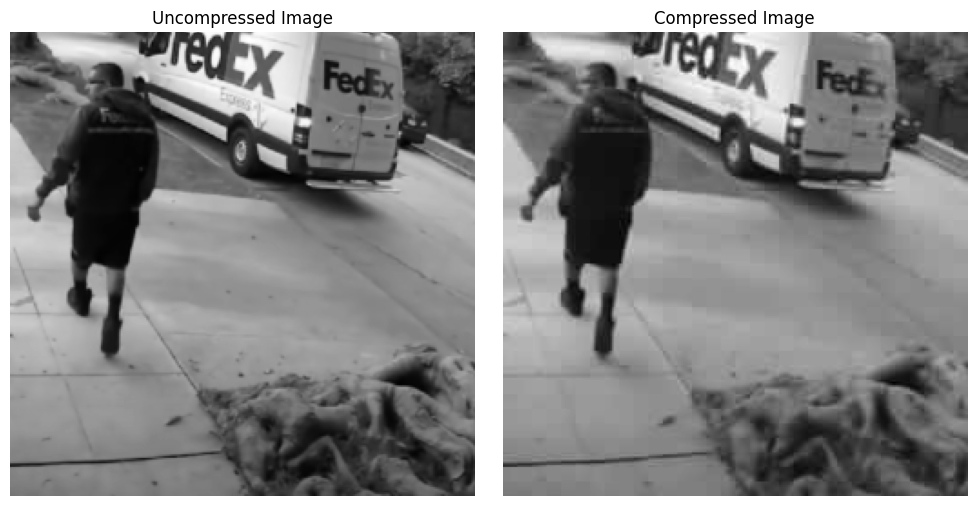

In [11]:
# Define the file paths
compressed_img_path = 'compressed_image.bmp'
uncompressed_img_path = 'uncompressed.bmp'

# Read the images
compressed_img = cv2.imread(compressed_img_path, cv2.IMREAD_GRAYSCALE)
uncompressed_img = cv2.imread(uncompressed_img_path, cv2.IMREAD_GRAYSCALE)

# Check if images are read successfully
if compressed_img is None:
    print(f"Error: Unable to read {compressed_img_path}")
if uncompressed_img is None:
    print(f"Error: Unable to read {uncompressed_img_path}")

# Display images side by side using Matplotlib
plt.figure(figsize=(10, 5))

# Display uncompressed image
plt.subplot(1, 2, 1)
plt.imshow(uncompressed_img, cmap='gray')
plt.title('Uncompressed Image')
plt.axis('off')  # Hide axis

# Display compressed image
plt.subplot(1, 2, 2)
plt.imshow(compressed_img, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')  # Hide axis

# Show the plot
plt.tight_layout()
plt.show()


Tiến hành do thời gian chạy trên toàn bộ tập dữ liệu, bao gồm: tổng thời gian chạy của code tuần tự, thời gian chạy thuật toán DCT, thuật toán lượng tử hóa và zigzag

In [12]:
folder_path = './human detection dataset/dataset'

dct_sum_time = 0
QUANTIZATION_sum_time = 0
zigzag_sum_time = 0
total_time = 0

total_start = time.time()
for i in range(1,25):
    file_path = os.path.join(folder_path, f'{i}.png')
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    [h , w] = img.shape
    height = h
    width = w
    h = np.float32(h) 
    w = np.float32(w) 

    nbh = math.ceil(h/block_size)
    nbh = np.int32(nbh)

    nbw = math.ceil(w/block_size)
    nbw = np.int32(nbw)

    H =  block_size * nbh
    W =  block_size * nbw

    padded_img[0:height,0:width] = img[0:height,0:width]

    cv2.imwrite('uncompressed.bmp', np.uint8(padded_img))

    padded_img, dct_time, QUANTIZATION_time, zigzag_time = process_blocks(padded_img,block_size,QUANTIZATION_MAT, nbh, nbw)
    dct_sum_time += dct_time
    QUANTIZATION_sum_time += QUANTIZATION_time
    zigzag_sum_time += zigzag_time

    arranged = padded_img.flatten()

    bitstream = get_run_length_encoding(arranged)
    bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"

    file1 = open("image.txt","w")
    file1.write(bitstream)
    file1.close()
total_end = time.time()
total = total_end - total_start

print ('Total time: ', total, 's')
print ('DCT time: ', dct_sum_time, 's')
print ('Quantization time: ', QUANTIZATION_sum_time, 's')
print ('Zigzag time: ', zigzag_sum_time, 's')

Total time:  42.17343592643738 s
DCT time:  37.38498616218567 s
Quantization time:  1.4428434371948242 s
Zigzag time:  1.2974638938903809 s


<a id="2.5"></a>
## <span style='color:#004080'>Đánh giá</span>
Thời gian chạy của hàm DCT là lâu nhất, chiếm hơn 80% tổng thời gian chạy. Vậy nên ở phần song song hóa, nhóm sẽ tập trung phần lớn vào việc song song hóa thuật toán này. 

<a id="3"></a>
# <div style="text-align: left; background-color:#004d00; font-family:newtimeroman;color: white; padding: 14px; line-height: 1;border-radius:10px">3. Cài đặt song song</div>

<a id="3.1"></a>
## <span style='color:#004080'>3.1 Phiên bản song song cơ bản</span>

<a id="3.1.1"></a>
### <span style='color:#cc7a00'>3.1.1 Phân tích</span>
#### Quantization
Trong hàm Quantization ở đoạn code tuần tự, ta nhận thấy bước chia 2 ma trận (DCT và QUANTIZATION_MAT) là bước cần song song hóa. Và với bước này thì có thể tăng tốc bằng cách song song hóa việc tính toán các phần tử trong ma trận kết quả một cách độc lập với nhau.
#### DCT
Trong hàm DCT ở đoạn code tuần tự, ta có thể nhận thấy có 3 vòng lặp for lồng vào nhau để tính toán dct 1 chiều cho các hàng và cột của block. Ta có thể tiến hành song song hóa cho 2 bước này.

<a id="3.1.2"></a>
### <span style='color:#cc7a00'>3.1.2 Thiết kế</span>
#### Quantization
Gọi @cuda.jit thực hiện chia DCT với QUANTIZATION_MAT và cập nhật kết quả ở DCT_normalized với mỗi DCT_normalized[x, y] cập nhật bằng cách chia DCT[x, y] cho QUANTIZATION_MAT[x, y]

- Input:
    - DCT: Ma trận 2D chứa các hệ số DCT.
    - QUANTIZATION_MAT: Ma trận 2D có cùng kích thước với DCT, chứa các giá trị lượng tử hóa.
- Output:
    - DCT_normalized: Ma trận 2D có cùng kích thước với DCT và QUANTIZATION_MAT, nơi lưu trữ kết quả của phép chia.
#### DCT
Gọi @cuda.jit thực hiện tính toán DCT 2 chiều, với 2 bước DCT 1 chiều cho hàng và sau đó là cho cột: với result lữu trữ kết quả sau khi DCT 1 chiều cho tất cả các hàng và temp_result lữu trữ kết quả sau khi DCT 1 chiều cho tất cả các cột dựa vào kết quả từ result. Mỗi thread sẽ phụ trách tính toán 1 phần tử trong result và temp_result.
 - Input:
    - block: Ma trận 8x8 chứa dữ liệu của 1 khối hình ảnh
- Output:
    - temp_result: Ma trận chứa kết quả sau khi thực hiện DCT 2 chiều

In [81]:
@cuda.jit
def divide_cuda(DCT, QUANTIZATION_MAT, DCT_normalized):
    x, y = cuda.grid(2)
    if x < DCT.shape[0] and y < DCT.shape[1]:
        DCT_normalized[x, y] = int(DCT[x, y] / QUANTIZATION_MAT[x, y])

In [14]:
@cuda.jit
def process_1(block, result, temp_result):
    N = block.shape[0]
    factor = math.pi / (2.0 * N)
    i, k = cuda.grid(2)

    # Compute the DCT for each row
    if i < N and k < N:
        sum_val = 0.0
        for n in range(N):
            sum_val += block[i, n] * math.cos(factor * (2 * n + 1) * k)
        result[i, k] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
    # cuda.syncthreads()
    if i < N and k < N:
        sum_val = 0.0
        for n in range(N):
            sum_val += result[n, i] * math.cos(factor * (2 * n + 1) * k)
        temp_result[k, i] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
def dct2_v1(block):
    block_dim = (8, 8)
    grid_dim = (1, 1)
    result = np.zeros((8, 8), dtype=np.float32)
    temp_result = np.zeros((8, 8), dtype=np.float32)
    process_1[grid_dim, block_dim](block, result, temp_result)

    return temp_result

<a id="3.2"></a>
## <span style='color:#004080'>3.2 Phiên bản song song cải tiến 1</span>

<a id="3.2.1"></a>
### <span style='color:#cc7a00'>3.2.1 Phân tích</span>
#### Quantization
Trong hàm Quantization được song song một cách đơn giản nên có thể cải tiến bằng cách copy dữ liệu và sử dụng share memmory
#### DCT
Tương tự hàm Quantization DCT ở phiên bản cải tiến này sẽ tối ưu hóa bằng copy dữ liệu 

<a id="3.2.2"></a>
### <span style='color:#cc7a00'>3.2.2 Thiết kế</span>
#### Quantization
Thực hiện đưa dữ liệu từ các ma trận DCT và QUANTIZATION_MAT vào device (bằng hàm copy_to_device) và sử dụng share memory để lưu dữ liệu từ 2 mảng này. Đồng thời cũng cấp phát bộ nhớ trong GPU cho kết quả result
#### DCT
Thực hiện đưa dữ liệu từ các ma trận block vào device (bằng hàm copy_to_device) và cấp phát bộ nhớ trong GPU cho kết quả result


DCT version 2

In [47]:
@cuda.jit
def divide_cuda_process_v2(A, B, C): 
    s_A = cuda.shared.array((8, 8), dtype=A.dtype)
    s_B = cuda.shared.array((8, 8), dtype=A.dtype)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    c, r = cuda.grid(2)

    temp = 0

    for phase in range(math.ceil(A.shape[1] / 8)):
        if r < A.shape[0] and phase * 8 + tx < A.shape[1]:
            s_A[ty, tx] = A[r, phase * 8 + tx]
        else:
            s_A[ty, tx] = 0
        if phase * 8 + ty < B.shape[0] and c < B.shape[1]:
            s_B[ty, tx] = B[phase * 8 + ty, c]
        else:
            s_B[ty, tx] = 0

        cuda.syncthreads() 

        for i in range(8):
            temp += s_A[ty, i] * s_B[i, tx]

        cuda.syncthreads()

    if r < C.shape[0] and c < C.shape[1]:
        C[r, c] = temp


In [48]:
def divide_cuda_v2(A,B,C):
    d_A = cuda.to_device(A)
    d_B = cuda.to_device(B)
    d_C = cuda.device_array((A.shape[0], B.shape[1]), dtype=float)
    block_size = (8, 8)
    grid_size = (math.ceil(d_C.shape[1] / block_size[0]),
                math.ceil(d_C.shape[0] / block_size[1]))
    divide_cuda_process_v2[grid_size, block_size](d_A, d_B, d_C)
    C = d_C.copy_to_host()
    return C

In [91]:
def dct2_v2(block):

    N = 8

    block_dim = (8, 8)
    grid_dim = (1, 1)

    temp_result = np.zeros((N, N), dtype=np.float32)

    d_result = cuda.device_array((N, N), dtype=np.float32)
    d_temp_result = cuda.device_array((N, N), dtype=np.float32)

    d_block = cuda.to_device(block)

    process_1[grid_dim, block_dim](d_block, d_result, d_temp_result)

    temp_result = d_temp_result.copy_to_host()

    return temp_result

<a id="3.3"></a>
## <span style='color:#004080'>3.3 Phiên bản song song cải tiến 2</span>

<a id="3.3.1"></a>
### <span style='color:#cc7a00'>Phân tích</span>
Thực hiện tối ưu hóa hàm DCT bằng cách sử dụng share memory để tối ưu hóa việc tính toán trong GPU

<a id="3.3.2"></a>
### <span style='color:#cc7a00'>3.3.2 Thiết kế</span>
#### DCT
Sử dụng bộ nhớ share memory để lưu dữ liệu cho các ma trận block và result


DCT version 3

In [92]:
@cuda.jit
def process_2(block, result, temp_result):
    N = block.shape[0]
    factor = math.pi / (2.0 * N)
    i, k = cuda.grid(2)

    #Shared memory for the block
    shared_block = cuda.shared.array(shape=(8, 8), dtype=float32)
    shared_result = cuda.shared.array(shape=(8, 8), dtype=float32)

    # Load block into shared memory
    if i < N and k < N:
        shared_block[i, k] = block[i, k]
    cuda.syncthreads()

    # Compute the DCT for each row
    if i < N and k < N:
        sum_val = 0.0
        for n in range(N):
            sum_val += shared_block[i, n] * math.cos(factor * (2 * n + 1) * k)
        shared_result[i, k] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))

    # Compute the DCT for each column using shared memory
    if i < N and k < N:
        sum_val = 0.0
        for n in range(N):
            sum_val += shared_result[n, i] * math.cos(factor * (2 * n + 1) * k)
        temp_result[k, i] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))

def dct2_v3(block):

    N = 8

    block_dim = (8, 8)
    grid_dim = (1, 1)

    temp_result = np.zeros((N, N), dtype=np.float32)

    d_result = cuda.device_array((N, N), dtype=np.float32)
    d_temp_result = cuda.device_array((N, N), dtype=np.float32)

    d_block = cuda.to_device(block)

    process_2[grid_dim, block_dim](d_block, d_result, d_temp_result)

    temp_result = d_temp_result.copy_to_host()

    return temp_result

<a id="4"></a>
# <div style="text-align: left; background-color:#004d00; font-family:newtimeroman;color: white; padding: 14px; line-height: 1;border-radius:10px">4. Chạy và đánh giá</div>

In [93]:
def process_blocks_gpu(padded_img, block_size, QUANTIZATION_MAT,nbh, nbw):
    dct_time_1 = 0
    dct_time_2 = 0
    dct_time_3 = 0

    QUANTIZATION_time_1 = 0
    QUANTIZATION_time_2 = 0
    QUANTIZATION_time_3 = 0

    for i in range(nbh):
        # Compute start and end row index of the block
        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size
        
        
        for j in range(nbw):
            # Compute start & end column index of the block
            col_ind_1 = j*block_size                       
            col_ind_2 = col_ind_1+block_size
                      
            block_input = padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2]
            #version 1
            start = time.time()
            DCT = dct2_v1(np.ascontiguousarray(block_input))
            end = time.time()
            dct_time_1 += end - start

            #version 2
            start = time.time()
            DCT = dct2_v2(np.ascontiguousarray(block_input))
            end = time.time()
            dct_time_2 += end - start

            #version 3
            start = time.time()
            DCT = dct2_v3(np.ascontiguousarray(block_input))
            end = time.time()
            dct_time_3 += end - start

            #QUANTIZATION 1
            start = time.time()
            DCT_normalized = np.divide(DCT,QUANTIZATION_MAT).astype(int) 
            end = time.time()
            QUANTIZATION_time_1 += end - start

            #QUANTIZATION 2
            start = time.time()
            DCT_normalized = divide_cuda[(1, 1), (8, 8)](DCT, QUANTIZATION_MAT, DCT_normalized)
            end = time.time()
            QUANTIZATION_time_2 += end - start

            #QUANTIZATION 3
            start = time.time()
            DCT_normalized = divide_cuda_v2(DCT, np.linalg.inv(QUANTIZATION_MAT), DCT_normalized)
            end = time.time()
            QUANTIZATION_time_3 += end - start
                    
            reordered = zigzag(DCT_normalized)

            reshaped= np.reshape(reordered, (block_size, block_size)) 

            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped     

    return padded_img,dct_time_1,dct_time_2,dct_time_3,QUANTIZATION_time_1,QUANTIZATION_time_2,QUANTIZATION_time_3

In [94]:
dct_sum_time_1 = 0
dct_sum_time_2 = 0
dct_sum_time_3 = 0

dct_time_1 = 0
dct_time_2 = 0
dct_time_3 = 0

QUANTIZATION_time_1 = 0
QUANTIZATION_time_2 = 0
QUANTIZATION_time_3 = 0

QUANTIZATION_sum_time_1= 0 
QUANTIZATION_sum_time_2= 0 
QUANTIZATION_sum_time_3= 0 

for i in range(1,25):
    file_path = os.path.join(folder_path, f'{i}.png')
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    [h , w] = img.shape
    height = h
    width = w
    nbh = math.ceil(h/block_size)
    nbh = np.int32(nbh)

    nbw = math.ceil(w/block_size)
    nbw = np.int32(nbw)

    H =  block_size * nbh
    W =  block_size * nbw

    #padded_img = np.zeros((H,W))
    padded_img[0:height,0:width] = img[0:height,0:width]
    
    padded_img,dct_time_1,dct_time_2,dct_time_3,QUANTIZATION_time_1,QUANTIZATION_time_2,QUANTIZATION_time_3 = process_blocks_gpu(padded_img,block_size,QUANTIZATION_MAT, nbh, nbw)

    dct_sum_time_1 += dct_time_1
    dct_sum_time_2 += dct_time_2
    dct_sum_time_3 += dct_time_3

    QUANTIZATION_sum_time_1 += QUANTIZATION_time_1
    QUANTIZATION_sum_time_2 += QUANTIZATION_time_2
    QUANTIZATION_sum_time_3 += QUANTIZATION_time_3

    arranged = padded_img.flatten()

    bitstream = get_run_length_encoding(arranged)
    bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"
print('DCT version 1: ', dct_sum_time_1 ,'s')
print('DCT version 2: ', dct_sum_time_2 ,'s')
print('DCT version 3: ', dct_sum_time_3 ,'s')
print('Quantization version numpy: ', QUANTIZATION_sum_time_1 ,'s')
print('Quantization version 2: ', QUANTIZATION_sum_time_2 ,'s')
print('Quantization version 3: ', QUANTIZATION_sum_time_3 ,'s')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.

DCT version 1:  92.45599412918091 s
DCT version 2:  36.736329078674316 s
DCT version 3:  36.70051336288452 s
Quantization version numpy:  1.0257740020751953 s
Quantization version 2:  93.24964046478271 s
Quantization version 3:  60.772611141204834 s


<a id="4.1"></a>
### <span style='color:#cc7a00'>Đánh giá</span>
- Thời gian chạy gốc của hàm dct2 là 51s
    - Đối với version 1: chưa được tối ưu nên thời gian chạy gần như tương đương với phiên bản gốc
    - Đối với version 2,3: tối ưu việc sử dụng bộ nhớ và copy dữ liệu từ host vào device nên tốc độ chạy đã cải thiện rõ rệt
- Đối với hàm Quantization: có thể thấy tốc độ khi sử dụng hàm numpy nhanh hơn rất nhiều so với 2 phiên bản song điều này đến từ việc tính toán 2 ma trận nhỏ (8x8) sẽ tốn chi phí khởi động GPU quá nhiều lần dẫn đến thời gian lâu hơn 

### <span style='color:#cc7a00'>Phiên bản bonus</span>
Ở phiên bản này thực hiện hoàn toàn việc song song hóa tất cả các hàm CPU thay vì GPU 

In [95]:
@jit(parallel = True)
def zigzag_v2(input):
	h = 0
	v = 0
	vmin = 0
	hmin = 0
	vmax = input.shape[0]
	hmax = input.shape[1]  
	i = 0
	output = np.zeros(( vmax * hmax))
    #----------------------------------
	while ((v < vmax) and (h < hmax)):   	
		if ((h + v) % 2) == 0:               
			if (v == vmin):
				output[i] = input[v, h]       
				if (h == hmax):
					v = v + 1
				else:
					h = h + 1
				i = i + 1
			elif ((h == hmax -1 ) and (v < vmax)):
				output[i] = input[v, h] 
				v = v + 1
				i = i + 1
			elif ((v > vmin) and (h < hmax -1 )):    
				output[i] = input[v, h] 
				v = v - 1
				h = h + 1
				i = i + 1
       
		else:                                   
			if ((v == vmax -1) and (h <= hmax -1)):     
				output[i] = input[v, h] 
				h = h + 1
				i = i + 1       
			elif (h == hmin):                 
				output[i] = input[v, h] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
			elif ((v < vmax -1) and (h > hmin)):    
				output[i] = input[v, h] 
				v = v + 1
				h = h - 1
				i = i + 1
		if ((v == vmax-1) and (h == hmax-1)):         
			output[i] = input[v, h] 
			break

	return output

In [96]:
@jit(parallel = True)
def dct2_sp(block):
    N = len(block)
    result = np.zeros((N, N))
    factor = math.pi / (2.0 * N)
    
    # Compute the DCT for each row
    for i in prange(N):
        for k in prange(N):
            sum_val = 0.0
            for n in range(N):
                sum_val += block[i, n] * math.cos(factor * (2 * n + 1) * k)
            result[i, k] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
    # print(result)
    # Temporary array to hold intermediate results
    temp_result = np.zeros((N, N))
    
    # Compute the DCT for each column
    for j in prange(N):
        for k in prange(N):
            sum_val = 0.0
            for n in range(N):
                sum_val += result[n, j] * math.cos(factor * (2 * n + 1) * k)
            temp_result[k, j] = sum_val * (math.sqrt(2 / N) if k != 0 else math.sqrt(1 / N))
    
    return temp_result

In [97]:
@jit(parallel = True)
def process_blocks_gpu_v2(padded_img, block_size, QUANTIZATION_MAT,nbh, nbw):
    for i in prange(nbh):
        # Compute start and end row index of the block
        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size
              
        for j in prange(nbw):
            # Compute start & end column index of the block
            col_ind_1 = j*block_size                    
            col_ind_2 = col_ind_1+block_size
                      
            block_input = padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2]
            DCT = dct2_sp(np.ascontiguousarray(block_input))
            # block_input_dct = np.ascontiguousarray(DCT)
            DCT_normalized = np.empty_like(DCT, dtype=np.float32)
            DCT_normalized = np.divide(DCT,QUANTIZATION_MAT)
                    
            reordered = zigzag_v2(DCT_normalized)

            reshaped= np.reshape(reordered, (block_size, block_size)) 

            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped     

    return padded_img

In [98]:
def process_blocks_gpu_v1(padded_img, block_size, QUANTIZATION_MAT,nbh, nbw):
    for i in range(nbh):
        # Compute start and end row index of the block
        row_ind_1 = i*block_size                
        row_ind_2 = row_ind_1+block_size
              
        for j in range(nbw):
            # Compute start & end column index of the block
            col_ind_1 = j*block_size                    
            col_ind_2 = col_ind_1+block_size
                      
            block_input = padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2]
            DCT = dct2_v3(np.ascontiguousarray(block_input))
            # block_input_dct = np.ascontiguousarray(DCT)
            DCT_normalized = np.empty_like(DCT, dtype=np.float32)
            DCT_normalized = np.divide(DCT,QUANTIZATION_MAT)
                    
            reordered = zigzag(DCT_normalized)

            reshaped= np.reshape(reordered, (block_size, block_size)) 

            padded_img[row_ind_1 : row_ind_2 , col_ind_1 : col_ind_2] = reshaped     

    return padded_img

In [99]:
cpu_time = 0
gpu_time = 0
for i in range(1,25):
    file_path = os.path.join(folder_path, f'{i}.png')
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    [h , w] = img.shape
    height = h
    width = w
    nbh = math.ceil(h/block_size)
    nbh = np.int32(nbh)

    nbw = math.ceil(w/block_size)
    nbw = np.int32(nbw)

    H =  block_size * nbh
    W =  block_size * nbw

    padded_img[0:height,0:width] = img[0:height,0:width]

    cv2.imwrite('uncompressed.bmp', np.uint8(padded_img))

    start = time.time()
    padded_img_1 = process_blocks_gpu_v1(padded_img,block_size,QUANTIZATION_MAT, nbh, nbw)
    end = time.time()
    gpu_time += end - start

    start = time.time()
    padded_img_2 = process_blocks_gpu_v2(padded_img,block_size,QUANTIZATION_MAT, nbh, nbw)
    end = time.time()
    cpu_time += end - start

    arranged = padded_img_1.flatten()

    bitstream = get_run_length_encoding(arranged)
    bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"
    
    file1 = open("image.txt","w")
    file1.write(bitstream)
    file1.close()

print('CPU time: ', cpu_time, 's')
print('GPU time: ', gpu_time, 's')

CPU time:  19.94449496269226 s
GPU time:  44.47024321556091 s


- Đánh giá: Đối với phiên bản song song trên CPU này, việc tính toán các khối block 8x8 của 1 ảnh được thực hiện song song hóa nên tốc độ được cải thiện rõ rệt so với trên GPU.

### <span style='color:#cc7a00'> Kiểm tra lại thuật toán nén ảnh JPEG song song trên 1 ảnh bất kì</span>


In [100]:
file_path = os.path.join(folder_path, f'{100}.png')
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
[h , w] = img.shape
height = h
width = w
nbh = math.ceil(h/block_size)
nbh = np.int32(nbh)

nbw = math.ceil(w/block_size)
nbw = np.int32(nbw)

H =  block_size * nbh
W =  block_size * nbw

padded_img[0:height,0:width] = img[0:height,0:width]

cv2.imwrite('uncompressed.bmp', np.uint8(padded_img))

padded_img_1 = process_blocks_gpu_v1(padded_img,block_size,QUANTIZATION_MAT, nbh, nbw)

arranged = padded_img_1.flatten()

bitstream = get_run_length_encoding(arranged)
bitstream = str(padded_img.shape[0]) + " " + str(padded_img.shape[1]) + " " + bitstream + ";"
    
file1 = open("image.txt","w")
file1.write(bitstream)
file1.close()

In [101]:
# Reading image.txt to decode it as image
with open('image.txt', 'r') as myfile:
    image=myfile.read()

# spplits into tokens seperated by space characters
details = image.split()

# just python-crap to get integer from tokens : h and w are height and width of image (first two items)
h = int(''.join(filter(str.isdigit, details[0])))
w = int(''.join(filter(str.isdigit, details[1])))

# declare an array of zeros (It helps to reconstruct bigger array on which IDCT and all has to be applied)
array = np.zeros(h*w).astype(int)


# some loop var initialisation
k = 0
i = 2
x = 0
j = 0


# This loop gives us reconstructed array of size of image

while k < array.shape[0]:
# Oh! image has ended
    if(details[i] == ';'):
        break
# This is imp! note that to get negative numbers in array check for - sign in string
    if "-" not in details[i]:
        array[k] = int(''.join(filter(str.isdigit, details[i])))        
    else:
        array[k] = -1*int(''.join(filter(str.isdigit, details[i])))        

    if(i+3 < len(details)):
        j = int(''.join(filter(str.isdigit, details[i+3])))

    if j == 0:
        k = k + 1
    else:                
        k = k + j + 1        

    i = i + 2

array = np.reshape(array,(h,w))

# loop for constructing intensity matrix form frequency matrix (IDCT and all)
i = 0
j = 0
k = 0

# initialisation of compressed image
padded_img = np.zeros((h,w))

while i < h:
    j = 0
    while j < w:        
        temp_stream = array[i:i+8,j:j+8]                
        block = inverse_zigzag(temp_stream.flatten(), int(block_size),int(block_size))            
        de_quantized = np.multiply(block,QUANTIZATION_MAT)                
        padded_img[i:i+8,j:j+8] = cv2.idct(de_quantized)        
        j = j + 8        
    i = i + 8

# clamping to  8-bit max-min values
padded_img[padded_img > 255] = 255
padded_img[padded_img < 0] = 0

# compressed image is written into compressed_image.mp file
cv2.imwrite("compressed_image.bmp",np.uint8(padded_img))


True

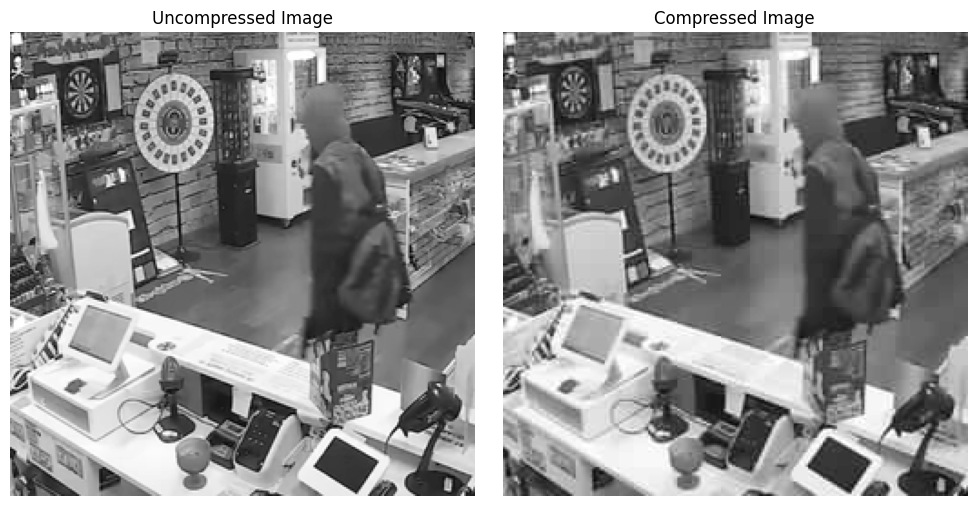

In [102]:
# Define the file paths
compressed_img_path = 'compressed_image.bmp'
uncompressed_img_path = 'uncompressed.bmp'

# Read the images
compressed_img = cv2.imread(compressed_img_path, cv2.IMREAD_GRAYSCALE)
uncompressed_img = cv2.imread(uncompressed_img_path, cv2.IMREAD_GRAYSCALE)

# Check if images are read successfully
if compressed_img is None:
    print(f"Error: Unable to read {compressed_img_path}")
if uncompressed_img is None:
    print(f"Error: Unable to read {uncompressed_img_path}")

# Display images side by side using Matplotlib
plt.figure(figsize=(10, 5))

# Display uncompressed image
plt.subplot(1, 2, 1)
plt.imshow(uncompressed_img, cmap='gray')
plt.title('Uncompressed Image')
plt.axis('off')  # Hide axis

# Display compressed image
plt.subplot(1, 2, 2)
plt.imshow(compressed_img, cmap='gray')
plt.title('Compressed Image')
plt.axis('off')  # Hide axis

# Show the plot
plt.tight_layout()
plt.show()


<a id="4"></a>
# <div style="text-align: left; background-color:#004d00; font-family:newtimeroman;color: white; padding: 14px; line-height: 1;border-radius:10px">4. Tổng kết</div>

## 4.1. Những gì đã làm được
- Song song hóa thuật toán DCT
- Song song hóa thuật toán quantization
- Thực hiện song song hóa tính toán các block trên CPU cho ảnh

## 4.2. Những gì chưa làm được
- Tối ưu cải thiện thuật toán DCT để cải thiện tốc độ
- Thực hiện song song hóa tính toán các block trên GPU cho ảnh

## 4.3. Những gì sẽ làm 
- Thực hiện song song hóa tính toán các block trên GPU cho ảnh

## 4.4. Khó khăn gặp phải 
- Làm quen với thư viện cuda của python
- Việc kiểm soát các thư viện bên ngoài trong code tuần tự khi áp dụng sang phiên bản song song
